## Problem 1

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy.stats
import statsmodels.api as sm
import copy
import time
from scipy.optimize import minimize
from scipy import stats
from scipy.stats import skew, kurtosis

In [2]:
def sim_CBM(num,p0,sigma=0.2,mu=0):
    np.random.seed(8)
    r = np.random.normal(mu,sigma,num)
    p = np.zeros(num)
    for i in range(num):
        p[i] = p0 + r[i]
    return np.mean(p), np.std(p)

def sim_ARS(num,p0,sigma=0.2,mu=0):
    np.random.seed(8)
    r = np.random.normal(mu,sigma,num)
    p = np.zeros(num)
    for i in range(num):
        p[i] = p0*(1+r[i])
    return np.mean(p), np.std(p)

def sim_GBM(num,p0,sigma=0.2,mu=0):
    np.random.seed(8)
    r = np.random.normal(mu,sigma,num)
    p = np.zeros(num)
    for i in range(num):
        p[i] = p0*np.exp(r[i])
    return np.mean(p), np.std(p)

In [3]:
num, p0 = 10000, 100
sigma, mu = 0.2, 0
exp1, std1 = sim_CBM(num,p0, sigma)
exp2, std2 = sim_ARS(num,p0, sigma)
exp3, std3 = sim_GBM(num,p0, sigma)
print('CBM sim: ', exp1, std1)
print('CBM exp: ', p0, sigma)
print('ARS sim: ', exp2, std2)
print('ARS exp: ', p0, p0*sigma)
print('GBM sim: ', exp3, std3)
print('GBM exp: ', p0*np.exp(mu+sigma**2/2), p0*np.exp(sigma**2/2)*np.sqrt(np.exp(sigma**2)-1))

CBM sim:  100.00018745127639 0.20091815292353055
CBM exp:  100 0.2
ARS sim:  100.01874512763969 20.09181529235305
ARS exp:  100 20.0
GBM sim:  102.05808791364825 20.714413496016057
GBM exp:  102.02013400267558 20.60977765104959


## Problem 2

In [4]:
def return_calculate(prices, method='DISCRETE'):
    price = prices.pct_change().dropna()
    if method.upper() == "DISCRETE":
        return price
    elif method.upper() == "LOG":
        return np.log(price)

In [5]:
prices = pd.read_csv("DailyPrices.csv")
prices.drop(['Date'],axis=1,inplace=True)
returns = prices.copy()
returns = returns.apply(lambda x: return_calculate(x))
meta = returns['META']-returns['META'].mean()

In [6]:
def var_normal(returns, num_sim=10000, alpha=0.05):
    np.random.seed(8)
    sim_returns = np.random.normal(np.mean(returns),np.std(returns),size=num_sim)
    var_normal = np.percentile(sim_returns,alpha*100)
    return [sim_returns, var_normal]

def exp_weighted_cov(returns, lambd):
    t = len(returns)
    weight = np.zeros(t)
    for i in range(1,t+1):
        weight[t-i] = (1-lambd)*lambd**(i-1)
    weight = weight/sum(weight)
    returns = returns - returns.mean()
    return returns.T @ (np.diag(weight) @ returns)

def var_exp_weighted(returns, num_sim=10000, alpha=0.05):
    # np.random.seed(8)
    sigma = np.sqrt(exp_weighted_cov(returns, 0.94))
    sim_returns = np.random.normal(np.mean(returns),sigma,size=num_sim)
    var_exp_weighted = np.percentile(sim_returns,alpha*100)
    return [sim_returns, var_exp_weighted]

def t_ll(params, returns):
    df = params[0]
    loc = params[1]
    scale = params[2]
    ll = stats.t.logpdf(returns, df, loc, scale).sum()
    return -ll

def var_t_MLE(returns,num_sim=10000, alpha=0.05):
    constraints=({"type":"ineq", "fun":lambda x: x[0]-1}, {"type":"ineq", "fun":lambda x: x[2]})
    returns = minimize(t_ll, [50, np.mean(returns), np.std(returns)], args=returns, constraints=constraints)
    df, loc, scale = returns.x[0],returns.x[1],returns.x[2]
    sim_returns = stats.t.rvs(df=df,loc=loc,scale=scale,size=num_sim)
    var_t_mle = np.percentile(sim_returns, alpha*100)
    return [sim_returns, var_t_mle]

def var_ar1(returns,num_sim=10000, alpha=0.05):
    ar1 = sm.tsa.ARIMA(returns,order=(1,0,0)).fit()
    alpha_ar1 = ar1.params[0]
    resid = ar1.resid
    sigma = np.std(resid)
    sim_returns = []
    np.random.seed(8)
    for i in range(num_sim):
        sim_returns.append(alpha_ar1*(returns.iloc[-1])+np.random.normal(0,sigma))
    var_ar1 = np.percentile(sim_returns, alpha*100)
    return [sim_returns, var_ar1]

def var_hist(returns, alpha=0.05):
    var_hist = np.percentile(returns, alpha*100)
    return [returns, var_hist]

In [7]:
def plot_sim(returns, var, title):
    plt.figure(figsize=(8,5))
    plt.hist(returns, density=True, bins=40)
    plt.axvline(var, color='r', linestyle='--', label="5% VaR")
    plt.title(title)
    plt.legend()
    plt.savefig('{}.png'.format(time.time()), facecolor='w',dpi=180)
    plt.show()

/Users/xinyiwan/miniforge3/envs/cyber/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyiwan/miniforge3/envs/cyber/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyiwan/miniforge3/envs/cyber/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


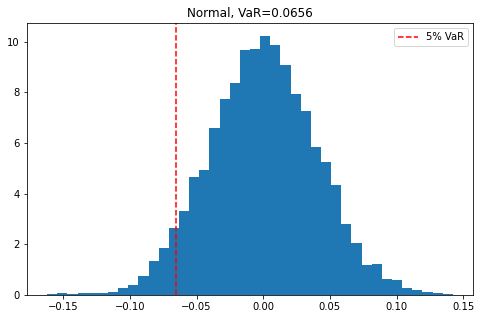

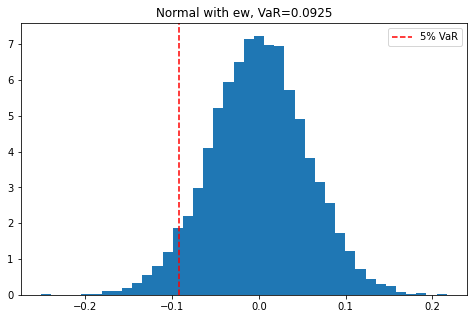

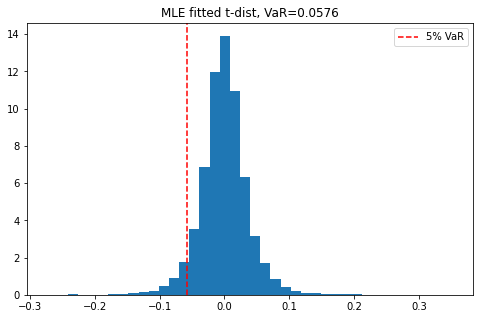

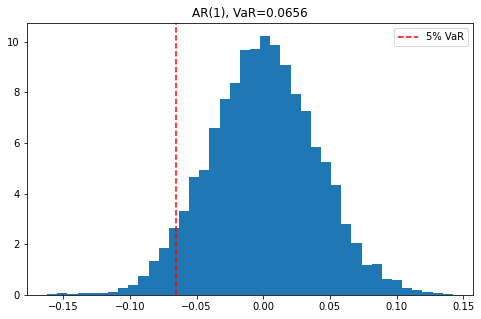

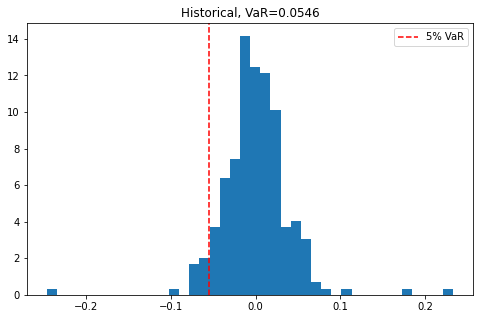

In [8]:
var_normal = var_normal(meta)
var_exp_weighted = var_exp_weighted(meta)
var_t_MLE = var_t_MLE(meta)
var_ar1 = var_ar1(meta)
var_hist = var_hist(meta)
plot_sim(var_normal[0], var_normal[1], 'Normal, VaR={:.03}'.format(-var_normal[1]))
plot_sim(var_exp_weighted[0], var_exp_weighted[1], 'Normal with ew, VaR={:.03}'.format(-var_exp_weighted[1]))
plot_sim(var_t_MLE[0],var_t_MLE[1], 'MLE fitted t-dist, VaR={:.03}'.format(-var_t_MLE[1]))
plot_sim(var_ar1[0], var_ar1[1], 'AR(1), VaR={:.03}'.format(-var_ar1[1]))
plot_sim(var_hist[0], var_hist[1], 'Historical, VaR={:.03}'.format(-var_hist[1]))

## Problem 3

In [9]:
portfolio = pd.read_csv("portfolio.csv")
port_a = list(portfolio.groupby('Portfolio'))[0][1]
port_b = list(portfolio.groupby('Portfolio'))[1][1]
port_c = list(portfolio.groupby('Portfolio'))[2][1]

In [10]:
def calc_portfolio_value(portfolio, prices):
    dict_current_prices = prices.iloc[-1,:].to_dict()
    portfolio['current_prices'] = portfolio['Stock'].map(dict_current_prices)
    current_prices = portfolio['current_prices'].values
    holdings = portfolio['Holding'].values
    portfolio_value = np.dot(holdings, current_prices)
    return current_prices, holdings, portfolio_value

In [11]:
def parametric_VAR(portfolio, prices, alpha=0.05, lambd = 0.94):
    '''
    portfolio: a dataframe with columns 'Stock' and 'Holding'
    prices: a dataframe with columns as stocks and rows as time points
    '''
    current_prices, holdings, portfolio_value = calc_portfolio_value(portfolio, prices)
    delta = np.identity(portfolio.shape[0])
    gradient = current_prices/portfolio_value*(delta@holdings)
    prices = prices.loc[:,portfolio['Stock']]
    returns = return_calculate(prices).reset_index()
    returns.drop('index',axis=1,inplace=True)
    cov = exp_weighted_cov(returns, lambd)
    VaR = -portfolio_value * stats.norm.ppf(alpha) * np.sqrt(gradient.T @ cov @ gradient)
    return VaR

In [12]:
def multivariate_normal_sim(cov, nsim, var_explained=1-1e-9):
    vals, vecs = np.linalg.eigh(cov)
    tot = sum(vals)
    for i in range(len(vals)):
        i = len(vals)-1-i
        if sum(vals[i:])/tot > var_explained:
            vals = vals[i:]
            vecs = vecs[:,i:]
            break
        if vals[i]<0:
            vals = vals[i+1:]
            vecs = vecs[:,i+1:]
            break
    B = vecs @ np.diag(np.sqrt(vals))
    # np.random.seed(9)
    z = np.random.normal(size = (len(vals),nsim))
    return B @ z

In [13]:
def monte_carlo_VAR(portfolio, prices, nsim=20000, lambd=0.94, alpha=0.05):
    current_prices, holdings, portfolio_value = calc_portfolio_value(portfolio, prices)
    
    prices = prices.loc[:,portfolio['Stock']]
    returns = return_calculate(prices).reset_index()
    returns.drop('index',axis=1,inplace=True)
    cov = exp_weighted_cov(returns, lambd)
    
    np.random.seed(66)
    sim_returns = multivariate_normal_sim(cov, nsim)
    sim_pv = (current_prices*holdings).T@sim_returns
    VaR = -np.percentile(sim_pv, alpha*100)
    return [sim_pv, VaR]

In [14]:
def historical_VAR(portfolio, prices, nsim=2000, lambd=0.94, alpha=0.05):
    current_prices, holdings, portfolio_value = calc_portfolio_value(portfolio, prices)
    
    prices = prices.loc[:,portfolio['Stock']]
    returns = return_calculate(prices).reset_index()
    returns.drop('index',axis=1,inplace=True)
    
    np.random.seed(99)
    sim_returns = returns.sample(nsim, replace=True)
    sim_pv = (current_prices*holdings).T@(sim_returns.T)
    VaR = -np.percentile(sim_pv, alpha*100)
    return [sim_pv,VaR]

In [15]:
print("Portfolio value:")
print("A: ", calc_portfolio_value(port_a, prices)[2])
print("B: ", calc_portfolio_value(port_b, prices)[2])
print("C: ", calc_portfolio_value(port_c, prices)[2])
print("Total: ", calc_portfolio_value(portfolio, prices)[2])
print('')
print("Parametric VaR:")
print("A: ", parametric_VAR(port_a, prices))
print("B: ", parametric_VAR(port_b, prices))
print("C: ", parametric_VAR(port_c, prices))
print("Total: ", parametric_VAR(portfolio, prices))
print('')
print("Normal Monte Carlo VaR:")
print("A: ", monte_carlo_VAR(port_a, prices)[1])
print("B: ", monte_carlo_VAR(port_b, prices)[1])
print("C: ", monte_carlo_VAR(port_c, prices)[1])
print("Total: ", monte_carlo_VAR(portfolio, prices)[1])
print('')
print("Historical VaR:")
print("A: ", historical_VAR(port_a, prices)[1])
print("B: ", historical_VAR(port_b, prices)[1])
print("C: ", historical_VAR(port_c, prices)[1])
print("Total: ", historical_VAR(portfolio, prices)[1])

Portfolio value:
A:  299950.05907389004
B:  294385.59081764997
C:  270042.8305277
Total:  864378.48041924

Parametric VaR:
A:  5670.202920147334
B:  4494.598410778259
C:  3786.5890108090503
Total:  13577.075418977076

Normal Monte Carlo VaR:
A:  5699.183225003909
B:  4553.182969396544
C:  3784.8565695798547
Total:  13458.326786016665

Historical VaR:
A:  6942.175943787615
B:  6205.73684253106
C:  5265.970958465615
Total:  17929.4779504177


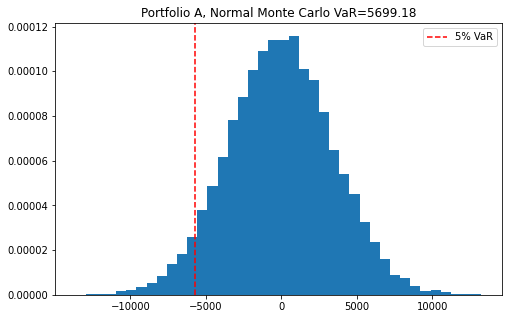

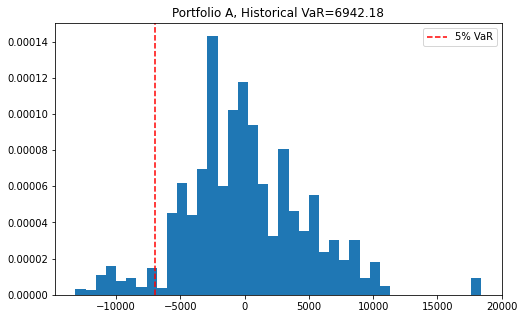

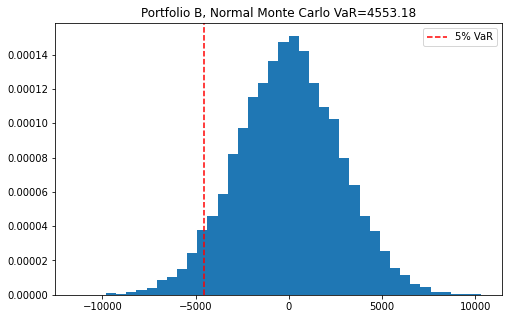

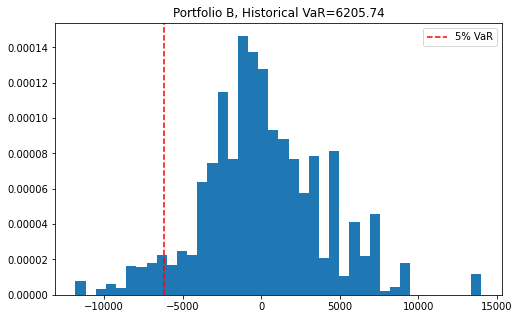

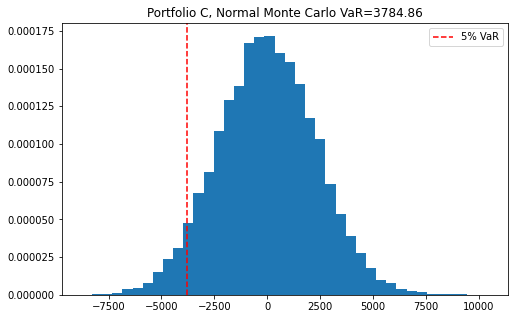

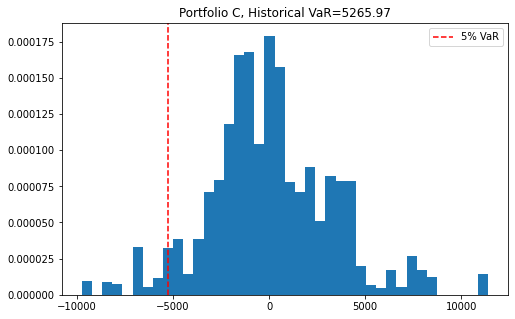

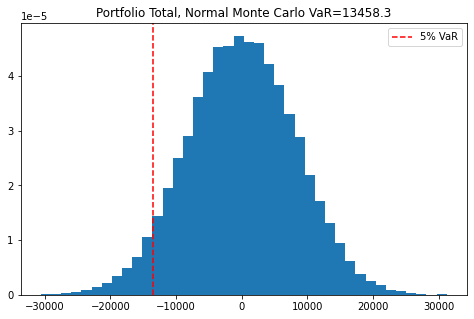

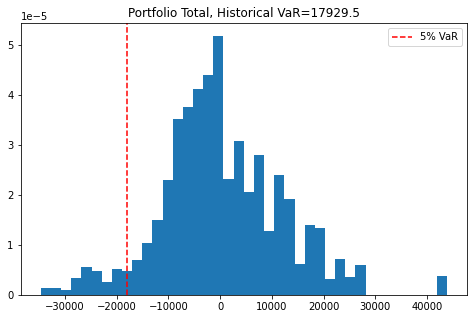

In [16]:
l = [port_a, port_b, port_c, portfolio]
port = ['A','B','C','Total']
for i in range(4):
    var = monte_carlo_VAR(l[i], prices)
    plot_sim(var[0], -var[1], 'Portfolio {}, Normal Monte Carlo VaR={:.6}'.format(port[i], var[1]))
    var = historical_VAR(l[i], prices)
    plot_sim(var[0], -var[1], 'Portfolio {}, Historical VaR={:.6}'.format(port[i], var[1]))

In [17]:
n = len(returns.columns)
skews, kurts = returns.skew(), returns.kurtosis()
pvalue_skew = stats.ttest_1samp(skews, 0.0)[1]
pvalue_kurt = stats.ttest_1samp(kurts, 0.0)[1]
print("skewness: " + "sample_size: {}, ".format(n) + "p-value: {}".format(pvalue_skew))
print("excess kurtosis: " + "sample_size: {}, ".format(n) + "p-value: {}".format(pvalue_kurt))

skewness: sample_size: 100, p-value: 0.20596646625143353
excess kurtosis: sample_size: 100, p-value: 1.4422895340027462e-10
